## Node class and method for computing node distances
Finding sorted position of every node to every other node is $\mathcal{O}(n^2\log{n})$. Pretty inefficient.

In [1]:
import numpy
from typing import List, Tuple

class Node:
    pos: numpy.array

    def __init__(self, pos):
        self.pos = pos

def compute_distances(nodes: List[Node]) -> List[List[Tuple[int, float]]]:
    """ return list (node_index, distance) pairs for every node. Distanced get sorted in ascending order. """
    distances = [[] for node in nodes]
    for i, node_a in enumerate(nodes):
        for j, node_b in enumerate(nodes):
            if i != j:
                node_tuple = (j, numpy.linalg.norm(node_a.pos - node_b.pos))
                distances[i].append(node_tuple)
        distances[i] = sorted(distances[i], key=lambda x: x[1])
    return distances

## Method returning angle in rads between two vectors

In [485]:
import numpy

# https://chadrick-kwag.net/get-rotation-angle-between-two-vectors/
def compute_rotation_angle(a, b):
    """ return rotation angle from vector a to vector b, in degrees.
    Args:
        a : np.array vector. format (x,y)
        b : np.array vector. format (x,y)
    Returns:
        angle [float]: degrees. 0~360
    """
    unit_vector_1 = a / numpy.linalg.norm(a)
    unit_vector_2 = b / numpy.linalg.norm(b)
    dot_product = numpy.dot(unit_vector_1, unit_vector_2)
    # Angle in radians
    angle = numpy.arccos(dot_product)
    # Determines how perpendicular two vectors are
    # 1 or -1 == completely perpendicalar, sign indicating direction
    # 0 == completely parallel
    c = numpy.cross(b,a)
    if c>0:
        angle = (2 * numpy.pi) - angle
    
    return angle

# Example use
# compute_rotation_angle([0, 1], [1, 0])

## Angle-based connection trial

![Angle diff logic](./angle_diff.png)

In [484]:
def get_angle_distance(a, b):
    """ Returns the distance between two angles (in radians)"""
    if (a < numpy.pi and b < numpy.pi) or (a > numpy.pi and b > numpy.pi):
        return abs(a - b)
    else:
        if a > numpy.pi: a, b = b, a
        return min(
            a + (2 * numpy.pi) - b,
            (numpy.pi - a) + (b - numpy.pi)
        )

def is_angle_between(a, b, theta):
    # Ensure a <= b
    if b < a:
        a, b = b, a
    
    offset = a
    a, b = 0, b - offset
    theta = theta - offset
    # Ensure theta is positive
    if theta < 0: theta = (numpy.pi * 2) + theta
    # Acute or obtuse angle
    return a <= theta <= b

print(is_angle_between(
    numpy.deg2rad(180),
    numpy.deg2rad(326),
    numpy.deg2rad(45)
))

False


Current bounds 135.00 326.31
--- 2
Current bounds 135.00 326.31
New angle 180.00
Moved left boundary 135.00 -> 180.00
--- 3
Current bounds 180.00 326.31
New angle 45.00
Skipped 3
180.0 326.3099324740202 45.00000000000001
Current bounds 225.00 315.00
--- 2
Current bounds 225.00 315.00
New angle 18.43
Moved right boundary to 315.00 -> 18.43
--- 3
Current bounds 225.00 18.43
New angle 321.34
Skipped 3
225.0 18.434948822922017 321.3401917459099
Current bounds 0.00 45.00
--- 2
Current bounds 0.00 45.00
New angle 344.05
Moved left boundary 0.00 -> 344.05
--- 3
Current bounds 344.05 45.00
New angle 26.57
Skipped 3
344.05460409907715 45.00000000000001 26.565051177077994
Current bounds 80.54 146.31
--- 2
Current bounds 80.54 146.31
New angle 141.34
Skipped 2
80.53767779197439 146.30993247402023 141.34019174590992
--- 3
Current bounds 80.54 146.31
New angle 164.05
Moved right boundary to 146.31 -> 164.05
Current bounds 225.00 260.54
--- 2
Current bounds 225.00 260.54
New angle 198.43
Moved left 

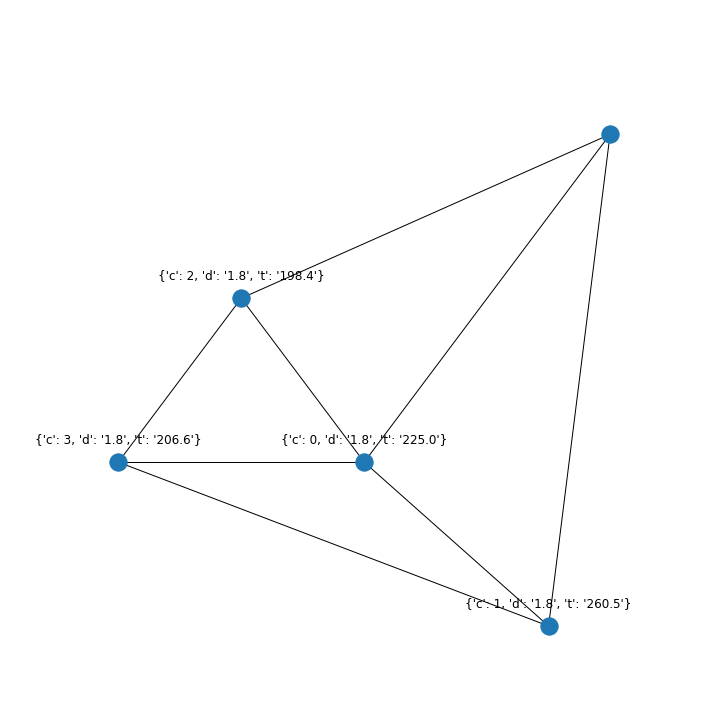

In [555]:
import networkx as nx
from matplotlib import pyplot
from numpy import rad2deg

nodes = [
    Node(numpy.array([0, 0])),
    Node(numpy.array([-1, 1])),
    Node(numpy.array([-2, 0])),
    Node(numpy.array([1.5, -1])),
    Node(numpy.array([2, 2])) # The algorithm should not connect this one
]
distances = compute_distances(nodes)
g = nx.Graph()
for i, node in enumerate(nodes):
    g.add_node(i, pos=node.pos)
pos = nx.get_node_attributes(g,'pos')


fig, ax = pyplot.subplots(1,1,figsize=(10,10), layout="constrained")

for i in range(0, len(nodes)):
    neighbors = []
    labels = dict()
    c = 0
    left = None
    right = None
    
    is_reflex_angle = False
    
    while distances[i]:
        # Initialize the first segment
        if left is None:
            idx_0, dist_0 = distances[i].pop(0)
            idx_1, dist_1 = distances[i].pop(0)
            g.add_edge(i, idx_0)
            g.add_edge(i, idx_1)
            angle_0 = compute_rotation_angle([1, 0], nodes[idx_0].pos - nodes[i].pos)
            angle_1 = compute_rotation_angle([1, 0], nodes[idx_1].pos - nodes[i].pos)
            labels[idx_0] = {
                'c': c, # Order in which the node was connected
                'd': '{:0.1f}'.format(distance),
                't': '{:0.1f}'.format(numpy.rad2deg(angle_0))
            }
            c += 1
            labels[idx_1] = {
                'c': c, # Order in which the node was connected
                'd': '{:0.1f}'.format(distance),
                't': '{:0.1f}'.format(numpy.rad2deg(angle_1))
            }
            c += 1
            left = angle_0
            right = angle_1
            if left > right:
                left, right = right, left

            # The angle between left and right is reflex from the start, so angle checks
            # must be initially inverted.
            if abs(right - left) > numpy.pi:
                is_reflex_angle = True

            print("Current bounds {:0.2f} {:0.2f}".format(rad2deg(left), rad2deg(right)))
            continue
            
        print("--- {}".format(c))
        print("Current bounds {:0.2f} {:0.2f}".format(rad2deg(left), rad2deg(right)))
            
        # Add more segments until no more can be added
        idx, dist = distances[i].pop(0)
        theta = compute_rotation_angle([1, 0], nodes[idx].pos - nodes[i].pos)
        
        print("New angle {:0.2f}".format(rad2deg(theta)))
  
        if (not is_reflex_angle and is_angle_between(left, right, theta))\
        or (is_reflex_angle and not is_angle_between(left, right, theta)):
            print("Skipped {}".format(c))
            print(rad2deg(left), rad2deg(right), rad2deg(theta))
            labels[idx] = {
                'c': c, # Order in which the node was connected
                'd': '{:0.1f}'.format(distance),
                't': '{:0.1f}'.format(numpy.rad2deg(theta))
            }
        else:
            if get_angle_distance(left, theta) < get_angle_distance(right, theta):
                print("Moved left boundary {:0.2f} -> {:0.2f}".format(rad2deg(left), rad2deg(theta)))
                left = theta
            else:
                print("Moved right boundary to {:0.2f} -> {:0.2f}".format(rad2deg(right), rad2deg(theta)))
                right = theta
            g.add_edge(i, idx)
            labels[idx] = {
                'c': c, # Order in which the node was connected
                'd': '{:0.1f}'.format(distance),
                't': '{:0.1f}'.format(numpy.rad2deg(theta))
            }
  
        if not is_reflex_angle and abs(right - left) > numpy.pi:
            is_reflex_angle = True
        
        c += 1

    
SHIFT_AMOUNT = 0.1
label_pos = {k: (v[0], v[1] + SHIFT_AMOUNT) for k, v in pos.items()}
nx.draw(g, pos=pos, with_labels=False, ax=ax)
# https://stackoverflow.com/questions/14547388/networkx-in-python-draw-node-attributes-as-labels-outside-the-node
nx.draw_networkx_labels(g, pos=label_pos, labels=labels, verticalalignment="bottom")
ax.set_xlim(tuple(i*1.2 for i in ax.get_xlim()))      # expand plot to fit labels
ax.set_ylim(tuple(i*1.2 for i in ax.get_ylim()))      # expand plot to fit labels
pyplot.show()

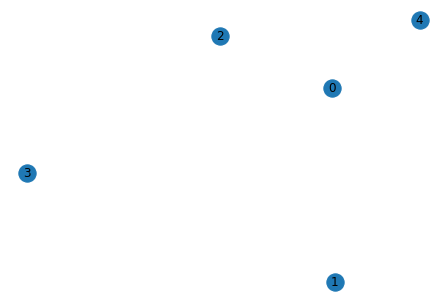

In [556]:
import numpy
import networkx as nx
import matplotlib.pyplot as plt
import copy

N_NODES = 5
nodes = []
for i in range(0, N_NODES):
    node = Node(
        numpy.random.rand(2)
    )
    nodes.append(node)

G = nx.Graph()
for i, node in enumerate(nodes):
    G.add_node(i, pos=node.pos)
    
G_p1 = copy.deepcopy(G)
pos = nx.get_node_attributes(G_p1,'pos')
nx.draw(G_p1, pos, with_labels=True)
plt.show()